In [1]:
import matplotlib.pyplot as plt
import math
import torch
from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils.get_nn_models import posterior_nn
import sbi.utils as utils

In [2]:
from stylized_module.stylized_cell import Stylized_Cell
from stylized_module.ecp import EcpMod, newposition
from stylized_module.recorder import Recorder

class Cell(Stylized_Cell):
    """Define single cell model using parent class Stylized_Cell"""
    def __init__(self,geometry=None,dL=30,vrest=-70.0):
        """
        Initialize cell model
        geometry: pandas dataframe of cell morphology properties
        dL: maximum segment length
        vrest: reversal potential of leak channel for all segments
        """
        super().__init__(geometry,dL,vrest)
        self.record_soma_v() # uncomment this if want to record soma voltage
    
    def set_channels(self,gl_soma=15e-5,gl_dend=1e-5):
        """Define biophysical properties, insert channels"""
#         self.set_all_passive(gl=0.0003)  # soma,dend both have gl
        for sec in self.all:
            sec.cm = 1.0
            sec.insert('pas')
            sec.e_pas = self._vrest
        self.soma.g_pas = 15e-5*5
        for sec in self.all[1:]:
            sec.g_pas = 1e-5*5
    
    def record_soma_v(self):
        self.v_rec = Recorder(self.soma(.5),'v')
    
    def v(self):
        """Return recorded soma membrane voltage in numpy array"""
        if hasattr(self,'v_rec'):
            return self.v_rec.as_numpy()

In [3]:
from neuron import h
import pandas as pd
import numpy as np

h.load_file('stdrun.hoc')

class Simulation(object):
    def __init__(self,geometry,electrodes,soma_injection,loc_param,geo_param=None,scale=1.0):
        """
        Initialize simulation object
        geometry: pandas dataframe of cell morphology properties
        electrodes: array of electrode coordinates, n-by-3
        soma_injection: vector of some injection waveform
        loc_param: location parameters, ncell-by-4 array
        geo_param: geometry parameters, ncell-by-k array, if not specified, use default properties in geometry
        scale: scaling factors of lfp magnitude, ncell-vector, if is single value, is constant for all cells
        """
        self.ncell = 0  # number of cells in this simulation
        self.cells = []  # list of cell object
        self.lfp = []  # list of EcpMod object
        self.define_geometry_entries()  # list of entries to geometry dataframe
        self.geometry = geometry.copy()
        self.electrodes = electrodes
        self.soma_injection = soma_injection
        self.set_loc_param(loc_param)  # setup variable location parameters
        self.set_geo_param(geo_param)  # setup variable geometry parameters
        self.set_scale(scale)  # setup scaling factors of lfp magnitude
        self.create_cells()  # create cell objects with properties set up
        self.t_vec = h.Vector( round(h.tstop/h.dt)+1 ).record(h._ref_t)  # record time
    
    def set_loc_param(self,loc_param):
        """Setup location parameters. loc_param ncell-by-4 array"""
        loc_param = np.array(loc_param)
        if loc_param.ndim==1:
            loc_param = np.expand_dims(loc_param,0)
        self.ncell = loc_param.shape[0]
        self.loc_param = [(np.insert(loc_param[i,:2],2,0.),loc_param[i,2:]) for i in range(self.ncell)]
    
    def set_geo_param(self,geo_param):
        """Setup geometry parameters. geo_param ncell-by-k array, k entries of properties"""
        if geo_param is None:
            self.geo_param = None
        else:
            geo_param = np.array(geo_param)
            if geo_param.ndim==1:
                geo_param = np.expand_dims(geo_param,0)
            if geo_param.shape[0]!=self.ncell:
                raise ValueError("geo_param number of rows does not match loc_param")
            self.geo_param = geo_param
    
    def set_scale(self,scale):
        if not hasattr(scale,'__len__'):
            self.scale = np.full(self.ncell,scale)
        else:
            scale = np.array(scale).ravel()
            if scale.size!=self.ncell:
                raise ValueError("scale size does not match loc_param rows")
            self.scale = scale
    
    def define_geometry_entries(self):
        """Define list of entries to geometry dataframe. Each entry is a pair of section id and property."""
        self.geo_entries = [
            (0,'R'),  # change soma radius
            (3,'L'),  # change trunk length
            (3,'R'),  # change trunk radius
            ([1,2],'R'),  # change dendrites radius
            (4,'R'),  # change tuft radius
            ([1,2,4],'L') # change dendrite length
        ]
    
    def set_geometry(self,geometry,geo_param):
        """Set property values from geo_param through each entry to geometry. Return dataframe"""
        geom = geometry.copy()
        for i,x in enumerate(geo_param):
            if x>=0:
                geom.loc[self.geo_entries[i]] = x
        return geom
    
    def create_cells(self):
        """Create cell objects with properties set up"""
        self.cells.clear()  # remove cell objects from previous run
        self.lfp.clear()
        if self.geo_param is None:
            for i in range(self.ncell):
                self.cells.append( Cell(geometry=self.geometry) )
        else:
            for i in range(self.ncell):
                geometry = self.set_geometry(self.geometry,self.geo_param[i,:])
                self.cells.append( Cell(geometry=geometry) )
        # add soma injection current and set up lfp recording
        for i,cell in enumerate(self.cells):
            cell.add_injection(sec_index=0,pulse=False,current=self.soma_injection,record=True)
            # Move cell location
            self.lfp.append( EcpMod(cell,self.electrodes,move_cell=self.loc_param[i],scale=self.scale[i]) )
#             # Alternatively, if number of segments in the cell is much larger then electrodes, then move the electrodes instead
#             translate, rotate = self.loc_param[i]
#             self.lfp.append( EcpMod(cell,newposition(translate,rotate,self.electrodes,move_frame=True),scale=self.scale[i]) )
    
    def run(self):
        """Run simulation"""
        h.run()
    
    def t(self):
        """Return simulation time vector"""
        return self.t_vec.as_numpy()
    
    def get_lfp(self,index=0):
        """Return LFP array of the cell by index, channels-by-time"""
        return self.lfp[index].calc_ecp()
    

## import in vivo trace and average to be 96 channels

In [4]:
start = 289
end = 385
dt = 1/30
IVTrace = np.array(pd.read_csv('cell360LFP.txt',header=None)).T
AvgTraces = np.mean(IVTrace.reshape(IVTrace.shape[0],4,96,order='F'),axis=1)  # easier way to average every 4 channels
time = np.linspace(start*dt,end*dt,end-start,endpoint=False)  # do not include the endpoint, so that the time interval is correct
IVTraces = AvgTraces[start:end,:]
maxIndx = np.argmax(np.absolute(AvgTraces).max(axis=0))  # find maximum absolute value from averaged traces
maxTrace = -IVTraces[:,maxIndx] + 20
maxArg = np.argmax(maxTrace)


# make default electrode coordinates

In [5]:
x = np.linspace(0,0,96)#np.zeros(a)#16 um apart
y = np.linspace(-1900,1900,96)
z = np.zeros(96)
pos = np.vstack((x,y,z)).T
posdf = pd.DataFrame(pos)
pos = np.array(posdf)

#### Begin setup the simulation

In [6]:
from neuron import h
import pandas as pd
import numpy as np

# Load geometry into pandas dataframe
geo_standard = pd.read_csv('geom_standard.csv',index_col='id')
# Load electrode coordinates (this is just for example. update it to be 96*3)
#elec_pos = pd.read_csv('linear_electrode.csv',sep=' ')[[x+'_pos' for x in list('xyz')]].values
elec_pos = posdf
# Basic settings for simulation
h.load_file('stdrun.hoc')
h.tstop = 4.
h.dt = 1/30
h.v_init = -70.0  # should be close to resting potential

# define example current injection waveform (later use in vivo LFP waveform in the channel with maximum amplitude)
t = np.arange(0,h.tstop+h.dt,h.dt)
t_inj = np.arange(5,15,h.dt)
#soma_injection = np.zeros(t.shape)
soma_injection = np.insert(maxTrace,0,0.)
#idx = int(5/h.dt)
#soma_injection[idx:idx+len(t_inj)] += 0.5*np.sin(2*np.pi*0.2*t_inj)  # simple sine wave

Create simulation object. Here run with only one cell and only location changed.

In [7]:
loc_param = [0,0,0,1,0]
geo_param = [4.0, -1, 0.2, -1, -1, 300.0]  # default value [6.0, 400.0, 0.1, 0.1, 0.1, 200.0]
geo_param = np.tile(geo_param,(3,1))  # Repeat to get 3-by-6 array.
sim = Simulation(geo_standard,elec_pos,soma_injection,loc_param,scale=100.)

This block of codes below can be put into the simulator function in sbi, to be run multiple times. You can run one cell at a time and run through all samples in series. Or you can run multiple cells at once, and gather the results as presimulated data for each round in sbi.

In [8]:
def model(param,t):
    
    from scipy import signal
    
   # sim.set_loc_param(loc_param[0][:4])#for test
   # sim.set_scale(loc_param[0][4])
    #for range from prior()
    # default value [6.0, 400.0, 0.1, 0.1, 0.1, 200.0]
    
    sim.set_loc_param(param[:5])
    scalVal = 10 ** param[5]
    sim.set_scale(scalVal)
    #gparamarray = np.array([6.0, 400.0, 0.1, 0.1, 0.1, 200.0])#[param[5],param[6], param[7], 0.1, 0.1, 200.0])
    #sim.set_geo_param(gparamarray)
    sim.create_cells()
    sim.run()
    lfp = sim.get_lfp()
    lfp = lfp.T
    b,a = signal.butter(2,100,'hp',fs=30000)    # order 2, 100 Hz, highpass, sampling rate = 40kHz
    filtered_lfp = signal.lfilter(b,a,lfp,axis=0)    # filter along row of the lfp 2d-array, if each row is a channel
    filtered_lfp = filtered_lfp[0:96]
        ###calculate lfp from current recordings
    simDict = {"traces": filtered_lfp,
              "time": t}
    return simDict

Changed dt
10.466666666666667
10.066666666666666
-12


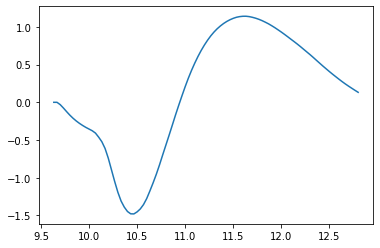

In [9]:
somalfp = model([10,0,0,1,0,1,-1,-1,-1],time)['traces'][:,47]
#sim.run()
#somalfp = sim.get_lfp()[48,:]
#somalfp = somalfp[1:]
plt.plot(time,somalfp)
print(time[np.argmin(somalfp)])
print(time[maxArg])
shift = maxArg - np.argmin(somalfp)
print(shift)
#sim = Simulation(geo_standard,elec_pos,soma_injection,loc_param)
sim = Simulation(geo_standard,elec_pos,soma_injection,loc_param,scale=100.)  # LFP scaled by 100 times for all cells

In [51]:
#from __future__ import print_function
#import torch
##################################for CNNN
#def simulation(params):
#    s = model(params,t)
 #   return torch.from_numpy(np.ravel(s['traces']))

In [52]:
import torch.nn as nn
import torch.nn.functional as F 
class SummaryNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 2D convolutional layer, input 96, with kernel_size 35, output 92x92
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        # Maxpool layer that reduces 96x96 image to 46x46
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # do not need to specify stride, by default stride=kernel_size
        
        # 2D convolutional layer, input 46x46, with kernel_size 3, output 44x44
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3)
        # Maxpool layer that reduces 44x44 image to 22x22
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # 2D convolutional layer, input 22x22, with kernel_size 3, output 20x20
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3)
        # Maxpool layer that reduces 20x20 image to 10x10
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected layer taking as input the 8 flattened output arrays from the maxpooling layer
        self.fc = nn.Linear(in_features=800, out_features=20) # 8*10*10=800

    def forward(self, x):
        x = x.view(-1,1,96,96) # (batch size,in_channels,height,length) -1 means not changing size of that dimension
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1,800) # (batch size, in_features)
        x = F.relu(self.fc(x))
        return x

embedding_net = SummaryNet()

In [53]:
old_position = pos
def statscalc(sumStat):
    
    mean_ch_vals = np.mean(sumStat)
    stdDev_ch_vals = np.std(sumStat)
    max_ch_val = np.array(max(sumStat)).reshape(-1)
    min_ch_val = np.array(min(sumStat)).reshape(-1)

    
    max_ch_pos = np.array(np.argmax(sumStat)).reshape(-1)#number of the channel at which max v occurs
    min_ch_pos = np.array(np.argmin(sumStat)).reshape(-1)
       

    y = old_position[max_ch_pos,1]
    orig_posMax = np.array([y]).reshape(-1)
    
    y = old_position[min_ch_pos,1]
    orig_posMin = np.array([y]).reshape(-1)
    
    All = np.hstack((orig_posMax,orig_posMin, mean_ch_vals, stdDev_ch_vals,max_ch_val,min_ch_val))
    
    return(All)
    

In [54]:
from scipy import stats as spstats

def Stats(results):
    """
    Calculates summary statistics
    results = model(params)
    """


    X = np.array(results['traces'])
    [a,b] = X.shape
    T = np.array(results['time'])
    
    avg = np.mean(X, axis = 0)# average voltage of each channel
    stdDev = np.std(X, axis = 0)# stDev of the voltage of each channel

    maxTrough = []
    timesT = []
    maxPeak = []
    timesP = [] 
   
    for i in range(0,b):
        maxPeak.append(max(X[:,i]))# max voltage of channel i
        timesP.append(T[np.argmax(X[:,i])]) # time at which the max sample was taken in channel i
        maxTrough.append(min(X[:,i]))# min voltage of channel i
        timesT.append(T[np.argmin(X[:,i])]) # time at which the min sample was taken in channel i
    avg = np.array(avg).reshape(-1)   
    stdDev = np.array(stdDev).reshape(-1)          
    tPeak_Trough = np.array(timesP) - np.array(timesT)       


    maxStats = np.array(statscalc(maxPeak)).reshape(-1)
    minStats = np.array(statscalc(maxTrough)).reshape(-1)
    avgStats = np.array(statscalc(avg)).reshape(-1) 
    relTimeStats = np.array(statscalc(tPeak_Trough)).reshape(-1)

  
            
    allStats = np.concatenate((avgStats,maxStats,relTimeStats, minStats,))
    

    return np.asarray(allStats)

In [55]:
from __future__ import print_function
import torch

def simulation(params):
    s = Stats(model(params,t))
    return torch.from_numpy(s)

In [57]:
Lows = torch.tensor([0,-2000, 0,-1,0,3,3,100,.05],dtype = float)
Highs = torch.tensor([200,2000,np.pi,1,np.pi,5,10,800,0.2],dtype = float)

prior = utils.BoxUniform(low=Lows, high= Highs)

#as a reminder, the prior is also defined earlier
ranParams = prior.sample()#example sample
ranParams

tensor([ 5.2281e+01, -2.8097e+01,  5.6776e-01,  8.1972e-01,  1.9615e+00,
         4.2617e+00,  4.1894e+00,  5.2833e+02,  7.9935e-02],
       dtype=torch.float64)

In [65]:
from sbi import inference
import torch
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
torch.manual_seed(0)
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(model='maf', 
                                      #embedding_net=embedding_net,
                                      hidden_features=10,
                                      num_transforms=2)

simulator, prior = prepare_for_sbi(simulation, prior)
# setup the inference procedure with the SNPE-C procedure


In [66]:
IVTrace_x0 = AvgTraces[start+shift:end+shift,:]
results = {"traces": IVTrace_x0,
          "time" : time}

In [ ]:

# 2 rounds: first round simulates from the prior, second round simulates from the obtained posterior.
num_rounds = 3
# The specific observation we want to focus the inference on.
x_o = Stats(results)#torch.tensor(np.ravel(IVTrace_x0))

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)
posteriors = []
proposal = prior
num_rounds=3
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000)
    
     # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

In [33]:
#x_o = torch.tensor(np.ravel(results['traces']))
x_o = x_o.reshape(1,96*96)

In [68]:
observation_trace = x_o
observation_summary_statistics = observation_trace
labels_params = [ r'x',r'y',r'theta',r'h', r'phi',r'scale',r'somaR',r'TrunkL',r'TrunkR']
samples = posterior.sample((1000,), x=x_o)#,sample_with_mcmc=True)

predicted post is:  tensor([1.6057e+02, 8.9999e+02, 8.3645e-02, 3.8167e-01, 4.9710e-01, 4.3207e+00,
        6.6916e+00, 7.0640e+02, 6.5692e-02])


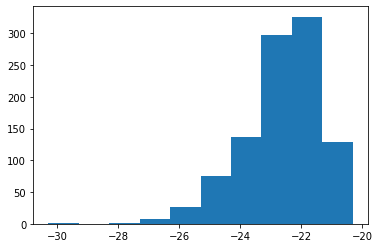

In [70]:
log_probability = posterior.log_prob(samples, x = x_o)
predicted_post_index = np.argmin(log_probability)
predicted_post = samples[predicted_post_index]
plt.hist(log_probability)
print("predicted post is: ",predicted_post)

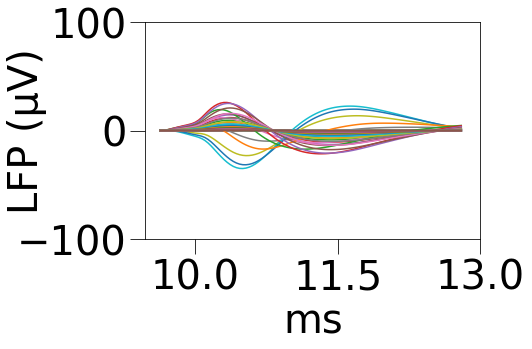

In [72]:
plt.plot(model(predicted_post,time)['time'],model(predicted_post,time)['traces'])

plt.xlabel('ms', fontsize=40)
plt.ylabel('LFP (\u03bcV)', fontsize = 40,labelpad=-30)
#plt.ylim([-50,50])
plt.xticks([10, 11.5,13],fontsize = 40)
plt.yticks([-100,0,100],fontsize = 40)

plt.tick_params(length = 15)

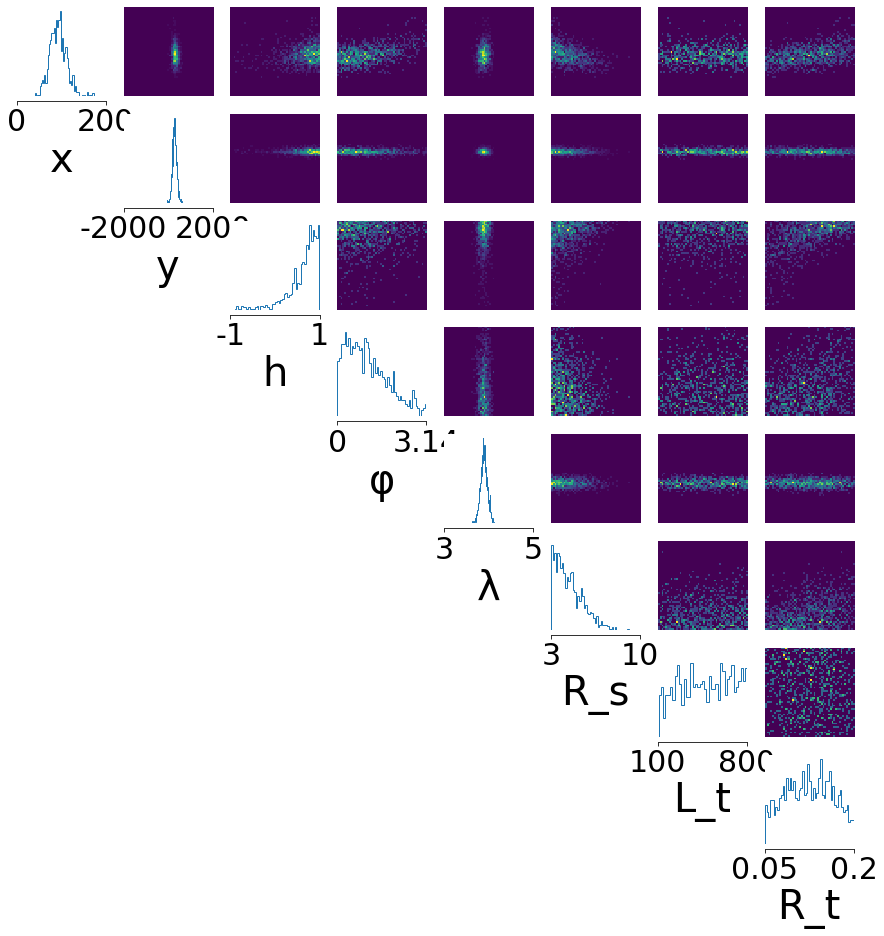

In [99]:

%matplotlib inline
#posterior.leakage_correction(observation_summary_statistics, num_rejection_samples=1000)
log_probability = posterior.log_prob(samples, x=observation_summary_statistics,norm_posterior=False)
fig, axes = utils.pairplot(samples,
                           limits=[[0,200],[-2000,2000], [-1,1],[0,np.pi],[3,5],[3,10],[100,800],[.05,0.2]],#,[3,12]],
                           ticks=[[0,200],[-2000,2000], [-1,1],[0,np.pi],[3,5],[3,10],[100,800],[.05,0.2]],#,[3,12]],
                           fig_size=(15,15),
                           #points=true_params,
                           points_offdiag={'markersize': 6},
                           labels = labels_params,
                           points_colors='r');
FS = 40


axes[0][0].set_xlabel('x',fontsize = FS,zorder=2.5)
axes[1][1].set_xlabel('y',fontsize = FS,zorder=2.5)
axes[2][2].set_xlabel('h',fontsize = FS,zorder=2.5)
axes[3][3].set_xlabel('\u03C6',fontsize=FS )
axes[4][4].set_xlabel('\u03BB',fontsize = FS)
axes[5][5].set_xlabel('R_s',fontsize = FS)
axes[6][6].set_xlabel('L_t',fontsize=FS)
axes[7][7].set_xlabel('R_t',fontsize=FS)
for i in range(8):
    axes[i][i].tick_params('x',labelsize=15,zorder=2.5)

LS = 30
axes[0][0].set_xticklabels(['0','200'],fontsize =LS)
axes[1][1].set_xticklabels(['-2000','2000'],fontsize =LS,zorder=4)
axes[2][2].set_xticklabels(['-1','1'],fontsize =LS)
axes[3][3].set_xticklabels(['0','3.14'],fontsize =LS)
axes[4][4].set_xticklabels(['3','5'],fontsize =LS)
axes[5][5].set_xticklabels(['3','10'],fontsize =LS)
axes[6][6].set_xticklabels(['100','800'],fontsize =LS)
axes[7][7].set_xticklabels(['0.05','0.2'],fontsize =LS)



plt.savefig('/home/ddopp4877/Desktop/cell360_GEO_KDE.pdf', bbox_inches='tight',transparent=True)

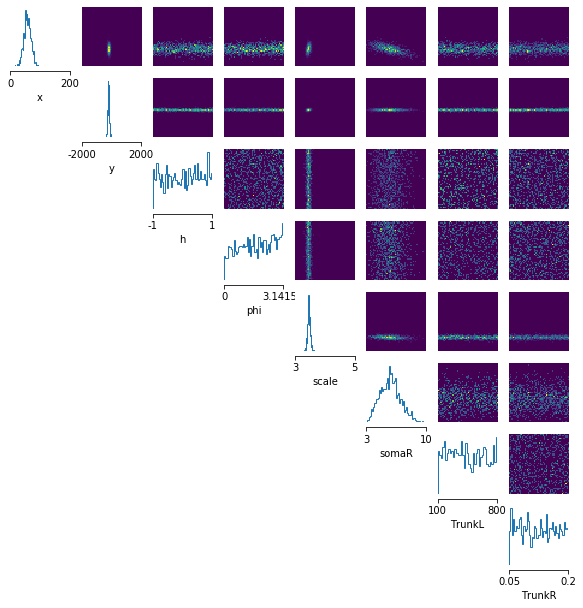

In [285]:
log_probability = posterior.log_prob(samples, x=observation_summary_statistics,norm_posterior=False)
fig, axes = utils.pairplot(samples,
                           limits=[[0,200],[-2000,2000], [0,np.pi],[-1,1],[0,np.pi],[3,5],[3,10],[100,800],[.05,0.2]],#,[3,12]],
                           ticks=[[0,200],[-2000,2000], [0,np.pi],[-1,1],[0,np.pi],[3,5],[3,10],[100,800],[.05,0.2]],#,[3,12]],
                           fig_size=(10,10),
                           #points=true_params,
                           points_offdiag={'markersize': 6},
                           labels = labels_params,
                           points_colors='r');

In [ ]:
condition = posterior.sample((1,))

_ = conditional_pairplot(
    density=posterior,
    condition=condition,
    limits=[[0,200],[-2000,2000], [-1,1],[0,np.pi],[3,5],[3,10],[100,800],[.05,0.2]],
    fig_size=(5,5)
)

parameters chosen by inference =  tensor([9.3493e+01, 2.9029e+02, 8.4785e-01, 5.5347e-01, 3.8809e+00, 3.5465e+00,
        7.9189e+02, 1.1667e-01], dtype=torch.float64)


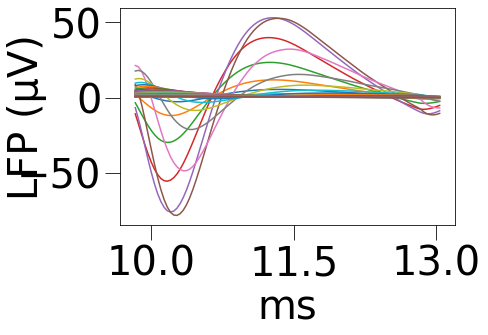

In [234]:
plt.plot(model(predicted_post,time)['time'],model(predicted_post,time)['traces'])

plt.xlabel('ms', fontsize=40)
plt.ylabel('LFP (\u03bcV)', fontsize = 40,labelpad=-30)

plt.xticks([10, 11.5,13],fontsize = 40)
plt.yticks([-50,0,50],fontsize = 40)

plt.tick_params(length = 15)

plt.savefig('/home/ddopp4877/Desktop/cell360GEOpred_Trace.pdf', bbox_inches='tight',transparent=True)
print("parameters chosen by inference = ",predicted_post)

(96, 96)


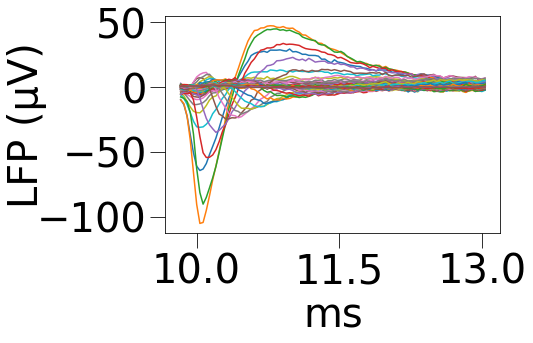

In [222]:
plt.plot(results['time'],results['traces'])

plt.xlabel('ms', fontsize=40)
plt.ylabel('LFP (\u03bcV)', fontsize = 40,labelpad=-10)

plt.xticks([10, 11.5,13],fontsize = 40)
plt.yticks([-100,-50,0,50],fontsize = 40)

plt.tick_params(length = 15)

plt.savefig('/home/ddopp4877/Desktop/cell360IV_Trace.pdf', bbox_inches='tight',transparent=True)

print(results['traces'].shape)

In [223]:
# function for calculating correlation coefficient, a value between -1 and 1.
def corrcoef(x,y):
    return (np.mean(x*y)-np.mean(x)*np.mean(y))/(np.std(x)*np.std(y))

# Calculate correlation coefficient between input x and y inside sliding time window
# (time should be the first axis, i.e. a column is a channel)
# Find the maximum correlation coefficient and the corresponding window location.
# Return first the maximum value, then return the index of the start point of corresponding window.
# If window_size is not specified, use the length of x as window size. Return the index of window in y.
# If window_size is specified, slide the window separately in x and y. Return the indices of windows in x and y respectively.
def max_corrcoef(x,y,window_size=None):
    if window_size is None:
        win = x.shape[0]
    else:
        win = window_size
    nx = x.shape[0]-win+1
    ny = y.shape[0]-win+1
    corr = np.empty((nx,ny))
    for i in range(nx):
        for j in range(ny):
            corr[i,j] = corrcoef(x[i:i+win,:].ravel(),y[j:j+win,:].ravel())
    maxind = np.argmax(corr)
    maxind = np.unravel_index(maxind,(nx,ny))
    max_corr = corr[maxind]
    if window_size is None:
        output = (max_corr,maxind[1])
    else:
        output = (max_corr,maxind[0],maxind[1])
    return output

In [236]:

max_corr,max_ind = max_corrcoef(results['traces'],model(postparams,time)['traces'])  # IVTraces has length 100, lfp has length 150, window size is 100
print(max_corr)  # return correlation coefficient and the index of the start point of the window in lfp

0.5138935908331737


In [237]:
np.corrcoef(results['traces'],model(postparams,time)['traces'])[0,1]

0.9504956979592646

# heatmaps


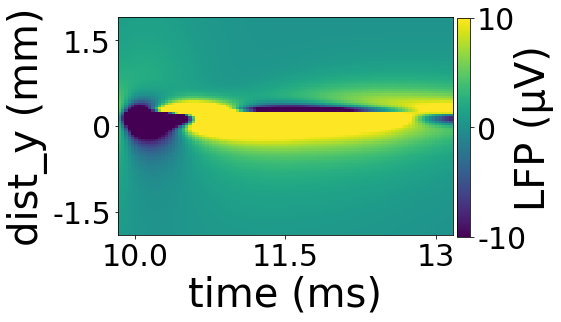

In [110]:
window=[4.8,5.2]
window=[0,20]
lfp =  model(predicted_post,time)['traces']
T= time
idx = (T>=window[0]) & (T<=window[1])
lfp_m = [np.min(lfp),np.max(lfp)]
lfp_m = [-10,10]
elec_d = pos[:,1] # electrode location (y-coordinate)
TT = T[idx]
lfp = lfp[idx]
lfp = lfp.transpose()
fig, ax = plt.subplots()
pcm = plt.pcolormesh(TT,elec_d/1000,lfp,cmap='viridis',vmin=lfp_m[0],vmax=lfp_m[1])
cbaxes = fig.add_axes([.91,0.118,.03,0.76])
cbar = fig.colorbar(pcm,ax=ax,ticks=[-10,0,10],cax = cbaxes)


FS = 40
NS = 30

cbar.set_label('LFP (\u03bcV)',fontsize=FS,labelpad=-12)
cbar.set_ticklabels(['-10','0','10'])
cbar.ax.tick_params(labelsize=NS)
#cbar.tick_params(['-10','0','10'],labelsize=15)

ax.set_xlabel('time (ms)',fontsize=FS)
ax.set_ylabel('dist_y (mm)',fontsize=FS)



ax.set_xticks([10,11.5,13])
ax.set_xticklabels(['10.0','11.5','13'],fontsize=NS)

ax.set_yticks([-1.5,0,1.5])
ax.set_yticklabels(['-1.5','0','1.5'],fontsize=NS)


plt.savefig('/home/ddopp4877/Desktop/cell360GEO_predHTMP.pdf', bbox_inches='tight',transparent=True)

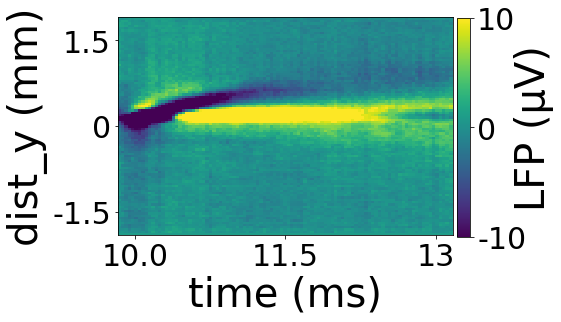

In [111]:
window=[4.8,5.2]
window=[0,20]
lfp =  results['traces']
T= time
idx = (T>=window[0]) & (T<=window[1])
lfp_m = [np.min(lfp),np.max(lfp)]
lfp_m = [-10,10]
elec_d = pos[:,1] # electrode location (y-coordinate)
TT = T[idx]
lfp = lfp[idx]
lfp = lfp.transpose()
fig, ax = plt.subplots()
pcm = plt.pcolormesh(TT,elec_d/1000,lfp,cmap='viridis',vmin=lfp_m[0],vmax=lfp_m[1])
cbaxes = fig.add_axes([.91,0.118,.03,0.76])
cbar = fig.colorbar(pcm,ax=ax,ticks=[-10,0,10],cax = cbaxes)


FS = 40
NS = 30

cbar.set_label('LFP (\u03bcV)',fontsize=FS,labelpad=-12)
cbar.set_ticklabels(['-10','0','10'])
cbar.ax.tick_params(labelsize=NS)
#cbar.tick_params(['-10','0','10'],labelsize=15)

ax.set_xlabel('time (ms)',fontsize=FS)
ax.set_ylabel('dist_y (mm)',fontsize=FS)



ax.set_xticks([10,11.5,13])
ax.set_xticklabels(['10.0','11.5','13'],fontsize=NS)

ax.set_yticks([-1.5,0,1.5])
ax.set_yticklabels(['-1.5','0','1.5'],fontsize=NS)


plt.savefig('/home/ddopp4877/Desktop/cell360IV_HTMP.pdf', bbox_inches='tight',transparent=True)